数据聚合与分组运算

对数据进行分组，并对各组应用一个函数，这是数据分析工作中的重要环节。Pandas提供了groupby功能，对数据进行切片、切块和摘要操作。本部分内容主要包括

1. 根据一个键或多个键（可以是函数、数组或DataFrame列名）拆分Pandas对象
2. 计算分组摘要，例如计数、均值、标准差，或者用户自定义函数
3. 对DataFrame列应用各种各样的函数
4. 计算透视表或交叉表
5. 执行分位数分析


In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

# GroupBy技术

split-apply-combine（拆分——应用——合并）过程

1. pandas对象（无论是Series、DataFrame，还是其它）中的数据会根据提供的一个或多个键被拆分（Split）为多组。拆分是在对象特定的轴上执行的，例如DataFrame可以在其行（axes=0）或列（axe=1)上进行分组。
2. 将一个函数应用(apply)到各个分组并产生一个新值。
3. 所有函数执行的结果合并(combine)到最终结果对象中。


In [3]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


In [4]:
df['data1'].mean()

0.23296944633426425

In [5]:
df['data2'].sum()

3.783517166545032

In [6]:
df.sum()

key1               aabba
key2     onetwoonetwoone
data1           1.164847
data2           3.783517
dtype: object

In [7]:
grouped = df['data1'].groupby(df['key1'])
grouped

+ 变量`grouped`是一个*GroubBy*对象，还没有进行任何计算，但已有分组计算所需要的信息。
+ *GroupBy*对象的`mean`方法可以计算分组平均值。

In [8]:
grouped.mean() # 返回Series

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

In [9]:
grouped.sum()

key1
a    2.240016
b   -1.075169
Name: data1, dtype: float64

In [10]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means # 具有层次化索引的Series

key1  key2
a     one     0.880536
      two     0.478943
b     one    -0.519439
      two    -0.555730
Name: data1, dtype: float64

In [11]:
means.unstack()

key2,one,two
key1,,
a,0.880536,0.478943
b,-0.519439,-0.555730


+ 分组键可以由多种形式，且类型不必相同：


1. 列表或数组，其长度与待分组的轴一样
2. 表示DataFrame某个列名的值
3. 字典或Series，给出待分组轴上的值与分组名之间的关系
4. 函数，用于处理轴索引或索引中的各个标签

## 列表或数组进行分组

+ 上述例子，**分组键为Series。实际上可以为任意长度合适的数组**。

In [12]:
df

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


In [13]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005    0.478943
            2006   -0.519439
Ohio        2005   -0.380219
            2006    1.965781
Name: data1, dtype: float64

- 还可以**将列名（可以是字符串、数字或其他Python对象）用作分组键**。


In [14]:
df
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.746672,0.910916
b,-0.537585,0.525384


In [15]:
df.groupby('key1').idxmax()

,data1,data2
key1,,
a,4,0
b,2,3


In [16]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.880536  1.319920
     two   0.478943  0.092908
b    one  -0.519439  0.281746
     two  -0.555730  0.769023

In [17]:
df.groupby(['key1','key2']).sum()

data1     data2
key1 key2                    
a    one   1.761073  2.639841
     two   0.478943  0.092908
b    one  -0.519439  0.281746
     two  -0.555730  0.769023

+ *GroupBy*的`size()`方法可以返回一个含有分组大小的Series

In [18]:
df.groupby('key1').size()

key1
a    3
b    2
dtype: int64

### 对分组进行迭代

+ `GroupBy`对象支持迭代，可以产生一组二元元组，由分组名和数据块组成。

In [19]:
for (name, group) in df.groupby('key1'):
    print("Group %s:" % name)
    print(group)

Group a:
  key1 key2     data1     data2
0    a  one -0.204708  1.393406
1    a  two  0.478943  0.092908
4    a  one  1.965781  1.246435
Group b:
  key1 key2     data1     data2
2    b  one -0.519439  0.281746
3    b  two -0.555730  0.769023


+ 对于多重键的情况，元组的第一个元素是由键值组成的元组
+ 可以对上述数据片段做任何操作，也可以转化为字典。

In [20]:
for ((k1, k2), group) in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one -0.204708  1.393406
4    a  one  1.965781  1.246435
('a', 'two')
  key1 key2     data1     data2
1    a  two  0.478943  0.092908
('b', 'one')
  key1 key2     data1     data2
2    b  one -0.519439  0.281746
('b', 'two')
  key1 key2    data1     data2
3    b  two -0.55573  0.769023


In [21]:
ll = list(df.groupby('key1'))
ll

[('a',
    key1 key2     data1     data2
  0    a  one -0.204708  1.393406
  1    a  two  0.478943  0.092908
  4    a  one  1.965781  1.246435),
 ('b',
    key1 key2     data1     data2
  2    b  one -0.519439  0.281746
  3    b  two -0.555730  0.769023)]

In [22]:
ll[0][0]
ll[0][1]

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
4,a,one,1.965781,1.246435


In [23]:
pieces = dict(list(df.groupby('key1')))
pieces

{'a':   key1 key2     data1     data2
 0    a  one -0.204708  1.393406
 1    a  two  0.478943  0.092908
 4    a  one  1.965781  1.246435,
 'b':   key1 key2     data1     data2
 2    b  one -0.519439  0.281746
 3    b  two -0.555730  0.769023}

In [24]:
pieces['b']

,key1,key2,data1,data2
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023


+ `groupby`默认是在axis=0上进行分组，通过设置也可以在其他任何轴上进行的分组。

In [25]:
df
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [26]:
grouped = df.groupby(df.dtypes,axis=1)
list(grouped)

[(dtype('float64'),
        data1     data2
  0 -0.204708  1.393406
  1  0.478943  0.092908
  2 -0.519439  0.281746
  3 -0.555730  0.769023
  4  1.965781  1.246435),
 (dtype('O'),
    key1 key2
  0    a  one
  1    a  two
  2    b  one
  3    b  two
  4    a  one)]

In [27]:
for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0 -0.204708  1.393406
1  0.478943  0.092908
2 -0.519439  0.281746
3 -0.555730  0.769023
4  1.965781  1.246435
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### 选取一个或一组列

由DataFrame产生的GroupBy对象，如果用一个或一组字符串列名对其进行索引，就能实现选取部分列进行聚合。

```Python
df.groupby('key1')['data1']

df.groupby('key1')[['data2']]
```

```Python
df['data1'].groupby(df['key1'])

df[['data2']].groupby(df['key1'])
```

In [28]:
df.groupby(['key1', 'key2'])

In [29]:
df.groupby(['key1', 'key2'])['data2']

In [30]:
df.groupby(['key1', 'key2'])[['data2']]

In [31]:
# 只计算data2列的平均值，并以DataFrame形式返回结果
ss = df.groupby(['key1', 'key2'])[['data2']]
ss
ss.mean()c

data2
key1 key2          
a    one   1.319920
     two   0.092908
b    one   0.281746
     two   0.769023

In [32]:
# 只计算data2列的平均值，并以Series形式返回结果
df.groupby(['key1', 'key2'])['data2'].mean()

key1  key2
a     one     1.319920
      two     0.092908
b     one     0.281746
      two     0.769023
Name: data2, dtype: float64

In [33]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped
s_grouped.mean()

key1  key2
a     one     1.319920
      two     0.092908
b     one     0.281746
      two     0.769023
Name: data2, dtype: float64

## 通过字典或Series进行分组

In [34]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [35]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}
mapping

{'a': 'red', 'b': 'red', 'c': 'blue', 'd': 'blue', 'e': 'red', 'f': 'orange'}

In [36]:
by_column = people.groupby(mapping, axis=1)
d=dict(list(by_column))
d['blue']
d['red']

,a,b,e
Joe,1.007189,-1.296221,1.352917
Steve,0.886429,-2.001637,-0.438570
Wes,-0.539741,NaN,-0.577087
Jim,0.124121,0.302614,1.343810
Travis,-0.713544,-0.831154,-0.860757


In [37]:
d

{'blue':                c         d
 Joe     0.274992  0.228913
 Steve  -0.371843  1.669025
 Wes          NaN -1.021228
 Jim     0.523772  0.000940
 Travis -2.370232 -1.860761,
 'red':                a         b         e
 Joe     1.007189 -1.296221  1.352917
 Steve   0.886429 -2.001637 -0.438570
 Wes    -0.539741       NaN -0.577087
 Jim     0.124121  0.302614  1.343810
 Travis -0.713544 -0.831154 -0.860757}

In [38]:
by_column.sum()

,blue,red
Joe,0.503905,1.063885
Steve,1.297183,-1.553778
Wes,-1.021228,-1.116829
Jim,0.524712,1.770545
Travis,-4.230992,-2.405455


In [39]:
arr = np.array(['red', 'red', 'blue', 'blue', 'red'])

In [40]:
people.groupby(arr, axis=1).sum()

,blue,red
Joe,0.503905,1.063885
Steve,1.297183,-1.553778
Wes,-1.021228,-1.116829
Jim,0.524712,1.770545
Travis,-4.230992,-2.405455


In [41]:
map_series = pd.Series(mapping)
map_series
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


## 通过函数进行分组

+ 字典或Series，定义了一种分组映射关系。
+ Python函数定义映射关系更有创意、抽象,**任何被当作分组键的函数都会在各个索引值上被调用一次，其返回的值被用作分组的名称**。
+ 函数和字典可以混用

In [42]:
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [43]:
# 根据人名长度进行分组
list(people.groupby(len))

[(3,
              a         b         c         d         e
  Joe  1.007189 -1.296221  0.274992  0.228913  1.352917
  Wes -0.539741       NaN       NaN -1.021228 -0.577087
  Jim  0.124121  0.302614  0.523772  0.000940  1.343810),
 (5,
                a         b         c         d        e
  Steve  0.886429 -2.001637 -0.371843  1.669025 -0.43857),
 (6,
                 a         b         c         d         e
  Travis -0.713544 -0.831154 -2.370232 -1.860761 -0.860757)]

In [44]:
people.groupby(len).sum()

,a,b,c,d,e
3,0.591569,-0.993608,0.798764,-0.791374,2.119639
5,0.886429,-2.001637,-0.371843,1.669025,-0.438570
6,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [45]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.539741 -1.296221  0.274992 -1.021228 -0.577087
  two  0.124121  0.302614  0.523772  0.000940  1.343810
5 one  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 two -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

## 根据索引级别进行分组

In [46]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.560145 -1.265934  0.119827 -1.063512  0.332883
1     -2.359419 -0.199543 -1.541996 -0.970736 -1.307030
2      0.286350  0.377984 -0.753887  0.331286  1.349742
3      0.069877  0.246674 -0.011862  1.004812  1.327195

In [47]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


# 数据聚合

+ 所谓聚合，指的是**任何能够从数组产生标量值的转换过程**
+ 许多常见的聚合运算，经过优化的groupby的方法

| 函数名 | 说明 |
|------|------|
|`count`|分组中非Na值的数量|
|`sum`|分组中非Na值的和|
|`mean`|分组中非Na值的平均值|
|`median`|分组中非Na值的算术中位数|
|`std`，`var`|无偏（分母为$n-1$）标准差和方差，即样本标准差和方差|
|`min`、`max`|分组中非Na值的最小值、最大值|
|`prod`|分组中非Na值的积|
|`first`、`last`|分组中第一个、最后一个非Na值|

In [48]:
df
grouped = df.groupby('key1')
grouped.mean()

,data1,data2
key1,,
a,0.746672,0.910916
b,-0.537585,0.525384


- 聚合运算并不是只能使用这些方法，实际上可以使用自己定义的聚合运算，还可以调用分组对象上已经定义好的任何方法。
- `quantile`可以计算Series或DataFrame列的样本分位数

In [49]:
# 样本分位数
grouped['data1'].quantile(0.9)

key1
a    1.668413
b   -0.523068
Name: data1, dtype: float64

+ 还可以使用自己定义的聚合运算，以及分组对象上已经定义好的任何方法
+ 如果要使用自己的聚合函数，只需将其传入`aggregate`或`agg`方法即可。

In [50]:
list(grouped)

[('a',
    key1 key2     data1     data2
  0    a  one -0.204708  1.393406
  1    a  two  0.478943  0.092908
  4    a  one  1.965781  1.246435),
 ('b',
    key1 key2     data1     data2
  2    b  one -0.519439  0.281746
  3    b  two -0.555730  0.769023)]

In [51]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.170488,1.300498
b,0.036292,0.487276


## 面像列的多函数应用

更高级的聚合功能。

In [52]:
tips = pd.read_csv('examples/tips.csv')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [53]:
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips.tail()
tips.head(6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
5,25.29,4.71,Male,No,Sun,Dinner,4,0.186240


In [54]:
grouped = tips.groupby(['day', 'smoker'])

In [55]:
grouped_pct = grouped['tip_pct']
grouped_pct.mean()

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [56]:
# 将函数名以字符串形式传入
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [57]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

+ 如果传入一个由**(name, function)**元组组成的列表，则各元组的第一个元素会被作为DataFrame的列名。

In [58]:
grouped_pct.agg(['mean', np.std])

mean       std
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

In [59]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

In [60]:
functions = ['count', 'mean', 'max']
result = grouped[['tip_pct', 'total_bill']].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

In [61]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

In [62]:
# 自定义名称的元组列表
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped[['tip_pct', 'total_bill']].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

- **不同的列应用不同的函数，向agg传入从列名映射到函数的字典**

In [63]:
# 不同的列应用不同的函数，向agg传入从列名映射到函数的字典
grouped.agg({'tip' : np.max, 'size' : 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [64]:
grouped.agg({'tip_pct' : [('小','min'), ('大','max'), 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                    小         大      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

## 以无索引形式返回聚合数据
+ `as_index=False`以禁用索引

In [65]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


In [66]:
tips.groupby(['day', 'smoker'], as_index=True).mean()

total_bill       tip      size   tip_pct
day  smoker                                          
Fri  No       18.420000  2.812500  2.250000  0.151650
     Yes      16.813333  2.714000  2.066667  0.174783
Sat  No       19.661778  3.102889  2.555556  0.158048
     Yes      21.276667  2.875476  2.476190  0.147906
Sun  No       20.506667  3.167895  2.929825  0.160113
     Yes      24.120000  3.516842  2.578947  0.187250
Thur No       17.113111  2.673778  2.488889  0.160298
     Yes      19.190588  3.030000  2.352941  0.163863

# 分组级运算和转换

- 聚合运算不过是分组运算的一种，是数据转换的一个特例：接受将一维数组转化为标量值的函数
- `transform`和`apply`方法可以执行更多的分组运算

In [67]:
df

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


- 如何在df中添加一个用于存放各索引分组平均值的列？可以先聚合再合并。

In [68]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.746672,0.910916
b,-0.537585,0.525384


In [69]:
k1_means = df.groupby('key1').mean().add_prefix('mean_')
k1_means

,mean_data1,mean_data2
key1,,
a,0.746672,0.910916
b,-0.537585,0.525384


In [70]:
pd.merge(df, k1_means, left_on='key1', right_index=True)

,key1,key2,data1,data2,mean_data1,mean_data2
0,a,one,-0.204708,1.393406,0.746672,0.910916
1,a,two,0.478943,0.092908,0.746672,0.910916
4,a,one,1.965781,1.246435,0.746672,0.910916
2,b,one,-0.519439,0.281746,-0.537585,0.525384
3,b,two,-0.555730,0.769023,-0.537585,0.525384


除此之外，我们还可以在groupby上使用`transform`方法。

- **`transform`会将一个函数应用到各个分组，然后将结果放置到适当的位置。**
- 如果分组产生的是一个标量值，则改值会被广播出去

In [71]:
df.groupby('key1').transform(np.mean)

,data1,data2
0,0.746672,0.910916
1,0.746672,0.910916
2,-0.537585,0.525384
3,-0.537585,0.525384
4,0.746672,0.910916


In [72]:
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [73]:
key = ['one', 'two', 'one', 'two', 'one']
people.groupby(key).mean()

,a,b,c,d,e
one,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309
two,0.505275,-0.849512,0.075965,0.834983,0.452620


In [74]:
people.groupby(key).transform(np.mean)

,a,b,c,d,e
Joe,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309
Steve,0.505275,-0.849512,0.075965,0.834983,0.452620
Wes,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309
Jim,0.505275,-0.849512,0.075965,0.834983,0.452620
Travis,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309


- 如果希望希望从各组中减去平均值，可以先创建一个距平化函数（demeaning function），然后将其传给`transform`

In [75]:
def demean(arr):
    return arr - arr.mean()

In [76]:
demeaned = people.groupby(key).transform(demean)
demeaned

,a,b,c,d,e
Joe,1.089221,-0.232534,1.322612,1.113271,1.381226
Steve,0.381154,-1.152125,-0.447807,0.834043,-0.891190
Wes,-0.457709,NaN,NaN,-0.136869,-0.548778
Jim,-0.381154,1.152125,0.447807,-0.834043,0.891190
Travis,-0.631512,0.232534,-1.322612,-0.976402,-0.832448


In [77]:
demeaned.groupby(key).sum()

,a,b,c,d,e
one,0.000000e+00,-2.220446e-16,0.0,2.220446e-16,0.0
two,-5.551115e-17,0.000000e+00,0.0,0.000000e+00,0.0


跟`aggregate`一样，`transform`也是一个存在着严格条件的函数：

- 传入的函数只能产生两种结果，要么产生一个可以广播的标量值(`np.mean`)，要么产生一个相同大小的结果数组。
- `apply`是一般化的GroupBy方法

## Apply：一般性的拆分--应用--合并

+ *GroupBy*对象的`apply`方法，会将待处理的对象拆分为多个片段，然后对各片段调用传入的函数，最后将各片段组合到一起，即：**split--apply--combine**

In [78]:
# 最高的n个tip_pct最高的值
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column, ascending=False)[-n:]
top(tips, n=6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
210,30.06,2.00,Male,Yes,Sat,Dinner,3,0.066534
187,30.46,2.00,Male,Yes,Sun,Dinner,5,0.065660
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
57,26.41,1.50,Female,No,Sat,Dinner,2,0.056797
102,44.30,2.50,Female,Yes,Sat,Dinner,3,0.056433
237,32.83,1.17,Male,Yes,Sat,Dinner,2,0.035638


In [79]:
top(tips,n=10,column='total_bill')

,total_bill,tip,sex,smoker,day,time,size,tip_pct
126,8.52,1.48,Male,No,Thur,Lunch,2,0.173709
135,8.51,1.25,Female,No,Thur,Lunch,2,0.146886
145,8.35,1.50,Female,No,Thur,Lunch,2,0.179641
218,7.74,1.44,Male,Yes,Sat,Dinner,2,0.186047
195,7.56,1.44,Male,No,Thur,Lunch,2,0.190476
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
111,7.25,1.00,Female,No,Sat,Dinner,1,0.137931
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345
92,5.75,1.00,Female,Yes,Fri,Dinner,2,0.173913
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733


In [80]:
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     130       19.08  1.50    Male     No  Thur   Lunch     2  0.078616
       146       18.64  1.36  Female     No  Thur   Lunch     3  0.072961
       48        28.55  2.05    Male     No   Sun  Dinner     3  0.071804
       0         16.99  1.01  Female     No   Sun  Dinner     2  0.059447
       57        26.41  1.50  Female     No   Sat  Dinner     2  0.056797
Yes    240       27.18  2.00  Female    Yes   Sat  Dinner     2  0.073584
       210       30.06  2.00    Male    Yes   Sat  Dinner     3  0.066534
       187       30.46  2.00    Male    Yes   Sun  Dinner     5  0.065660
       102       44.30  2.50  Female    Yes   Sat  Dinner     3  0.056433
       237       32.83  1.17    Male    Yes   Sat  Dinner     2  0.035638

- 如果传给`apply`的函数能够接受其他参数或关键字，则可以将这些内容放在函数名后面一并传入。

In [81]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker day                                                                    
No     Fri  99        12.46  1.50    Male     No   Fri  Dinner     2  0.120385
       Sat  111        7.25  1.00  Female     No   Sat  Dinner     1  0.137931
       Sun  6          8.77  2.00    Male     No   Sun  Dinner     2  0.228050
       Thur 149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
Yes    Fri  92         5.75  1.00  Female    Yes   Fri  Dinner     2  0.173913
       Sat  67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       Sun  172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345
       Thur 196       10.34  2.00    Male    Yes  Thur   Lunch     2  0.193424

In [82]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


- 在GroupBy中调用`describe`之类方法时，相当于运行了下面两条代码：
```python
f = lambda x:x.describe()
grouped.apply(f)
```

In [83]:
f = lambda x: x['tip_pct'].describe()
tips.groupby(['smoker']).apply(f)

tip_pct,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [84]:
rr = result.stack()
rr

smoker       
No      count    151.000000
        mean       0.159328
        std        0.039910
        min        0.056797
        25%        0.136906
        50%        0.155625
        75%        0.185014
        max        0.291990
Yes     count     93.000000
        mean       0.163196
        std        0.085119
        min        0.035638
        25%        0.106771
        50%        0.153846
        75%        0.195059
        max        0.710345
dtype: float64

In [85]:
rr.unstack(level=0)

smoker,No,Yes
count,151.000000,93.000000
mean,0.159328,0.163196
std,0.039910,0.085119
min,0.056797,0.035638
25%,0.136906,0.106771
50%,0.155625,0.153846
75%,0.185014,0.195059
max,0.291990,0.710345


## 禁止分组键
默认情况下，分组键会跟原始对象的索引键共同构成结果对象的层次化索引。将`group_keys=False`传入`groupby`可禁止该效果。

In [86]:
tips.groupby('smoker').apply(top,n=5)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     130       19.08  1.50    Male     No  Thur   Lunch     2  0.078616
       146       18.64  1.36  Female     No  Thur   Lunch     3  0.072961
       48        28.55  2.05    Male     No   Sun  Dinner     3  0.071804
       0         16.99  1.01  Female     No   Sun  Dinner     2  0.059447
       57        26.41  1.50  Female     No   Sat  Dinner     2  0.056797
Yes    240       27.18  2.00  Female    Yes   Sat  Dinner     2  0.073584
       210       30.06  2.00    Male    Yes   Sat  Dinner     3  0.066534
       187       30.46  2.00    Male    Yes   Sun  Dinner     5  0.065660
       102       44.30  2.50  Female    Yes   Sat  Dinner     3  0.056433
       237       32.83  1.17    Male    Yes   Sat  Dinner     2  0.035638

In [87]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
130,19.08,1.50,Male,No,Thur,Lunch,2,0.078616
146,18.64,1.36,Female,No,Thur,Lunch,3,0.072961
48,28.55,2.05,Male,No,Sun,Dinner,3,0.071804
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
57,26.41,1.50,Female,No,Sat,Dinner,2,0.056797
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0.073584
210,30.06,2.00,Male,Yes,Sat,Dinner,3,0.066534
187,30.46,2.00,Male,Yes,Sun,Dinner,5,0.065660
102,44.30,2.50,Female,Yes,Sat,Dinner,3,0.056433
237,32.83,1.17,Male,Yes,Sat,Dinner,2,0.035638


## Quantile and Bucket Analysis（分位数和桶分析）

+ 根据指定面元或样本分位数将数据拆分为多块的工具，譬如`cut`和`qcut`。
+ `pandas.cut`: Return indices of half-open bins to which each value of x belongs.
+ `pandas.qcut`:Quantile-based discretization function. Discretize variable into equal-sized buckets based on rank or based on sample quantiles.
+ 将上述函数与groupby结合起来进行分位数分析或桶分析。

为了便于分析，连续数据常常被离散化或拆分为“面元”。

In [88]:
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

将这些数据划分为“18到25”，“26到35”，“35-60”以及“60以上”几个面元，

In [89]:
bins = [18, 25, 35, 60, 100]
cats = pd.cut(ages, bins)
cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, interval[int64]): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

基本语法：
`pandas.cut(x,bins,right=True,labels=None,retbins=False,precision=3,include_lowest=False)`

- x：进行划分的一维数组
- bins: 整数---将x划分为多少个等间距的区间；序列—将x划分在指定的序列中
- 是否用标记来代替返回的bins

In [90]:
pd.cut(np.array([.2, 1.4, 2.5, 6.2, 9.7, 2.1]), 3)

[(0.19, 3.367], (0.19, 3.367], (0.19, 3.367], (3.367, 6.533], (6.533, 9.7], (0.19, 3.367]]
Categories (3, interval[float64]): [(0.19, 3.367] < (3.367, 6.533] < (6.533, 9.7]]

In [91]:
pd.cut(np.array([.2, 1.4, 2.5, 6.2, 9.7, 2.1]),
...        3, labels=["good", "medium", "bad"])

['good', 'good', 'good', 'medium', 'bad', 'good']
Categories (3, object): ['good' < 'medium' < 'bad']

- 类似的还有`pd.qcut`方法。
- `pd.cut`是根据值本身确定间隔确定，每个间隔是相同的；而`pd.qcut`是根据频率来确定间隔，即每个间隔包含的频率数是相同的

In [92]:
factors = np.random.randn(9)
factors

array([-0.9193, -1.5491,  0.0222,  0.7584, -0.6605,  0.8626, -0.01  ,
        0.05  ,  0.6702])

In [93]:
pd.cut(factors, 3)

[(-1.552, -0.745], (-1.552, -0.745], (-0.745, 0.0587], (0.0587, 0.863], (-0.745, 0.0587], (0.0587, 0.863], (-0.745, 0.0587], (-0.745, 0.0587], (0.0587, 0.863]]
Categories (3, interval[float64]): [(-1.552, -0.745] < (-0.745, 0.0587] < (0.0587, 0.863]]

In [94]:
pd.cut(factors, 3, labels=['A','B','C'])

['A', 'A', 'B', 'C', 'B', 'C', 'B', 'B', 'C']
Categories (3, object): ['A' < 'B' < 'C']

In [95]:
pd.qcut(factors, 3)

[(-1.5499999999999998, -0.227], (-1.5499999999999998, -0.227], (-0.227, 0.257], (0.257, 0.863], (-1.5499999999999998, -0.227], (0.257, 0.863], (-0.227, 0.257], (-0.227, 0.257], (0.257, 0.863]]
Categories (3, interval[float64]): [(-1.5499999999999998, -0.227] < (-0.227, 0.257] < (0.257, 0.863]]

In [96]:
pd.qcut(factors, 3, labels=['A','B','C'])

['A', 'A', 'B', 'C', 'A', 'C', 'B', 'B', 'C']
Categories (3, object): ['A' < 'B' < 'C']

- 可以将这些函数与GroupBy结合起来，实现对数据集的桶(bucket)和分位数(quantile)分析

In [97]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                      'data2': np.random.randn(1000)})
frame

,data1,data2
0,0.852965,-2.213133
1,-0.955869,0.758040
2,-0.023493,0.553933
3,-2.304234,0.339231
4,-0.652469,-0.688756
...,...,...
995,-0.612905,-0.620521
996,0.316447,0.227290
997,0.838295,0.922264
998,-1.034423,-2.153545


In [98]:
quartiles = pd.cut(frame.data1, 4)
quartiles[:10]

0     (0.489, 2.208]
1     (-1.23, 0.489]
2     (-1.23, 0.489]
3    (-2.956, -1.23]
4     (-1.23, 0.489]
5     (-1.23, 0.489]
6    (-2.956, -1.23]
7     (0.489, 2.208]
8     (0.489, 2.208]
9     (0.489, 2.208]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-2.956, -1.23] < (-1.23, 0.489] < (0.489, 2.208] < (2.208, 3.928]]

In [99]:
# 对分组求最小、最大、计数以及均值
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats)

data1                 
(-2.956, -1.23]  min       -3.399312
                 max        1.670835
                 count     94.000000
                 mean      -0.033333
(-1.23, 0.489]   min       -2.989741
                 max        3.260383
                 count    599.000000
                 mean      -0.006129
(0.489, 2.208]   min       -3.745356
                 max        2.954439
                 count    297.000000
                 mean       0.079090
(2.208, 3.928]   min       -1.929776
                 max        1.765640
                 count     10.000000
                 mean       0.024750
Name: data2, dtype: float64

In [100]:
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-2.956, -1.23]",-3.399312,1.670835,94.0,-0.033333
"(-1.23, 0.489]",-2.989741,3.260383,599.0,-0.006129
"(0.489, 2.208]",-3.745356,2.954439,297.0,0.079090
"(2.208, 3.928]",-1.929776,1.765640,10.0,0.024750


In [101]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels=False) # labels=False, return only integer indicators of the bins
grouping
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
0,-3.399312,1.670835,100.0,-0.036917
1,-2.153545,2.628441,100.0,-0.003666
2,-2.925113,2.527939,100.0,-0.065771
3,-2.315555,3.260383,100.0,0.067791
4,-2.047939,2.074345,100.0,-0.118539
5,-2.989741,2.184810,100.0,0.036889
6,-2.084231,2.458842,100.0,0.000588
7,-3.056990,2.954439,100.0,-0.041669
8,-3.745356,2.735527,100.0,0.110500


## 用于特定分组的值填充缺失值 

In [102]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1    0.329939
2         NaN
3    1.105913
4         NaN
5    1.561587
dtype: float64

In [103]:
s.fillna(s.mean())

0    0.999146
1    0.329939
2    0.999146
3    1.105913
4    0.999146
5    1.561587
dtype: float64

In [104]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']

In [105]:
group_key = ['East'] * 4 + ['West'] * 4

In [106]:
data = pd.Series(np.random.randn(8), index=states)
data

Ohio          0.406510
New York      0.359244
Vermont      -0.614436
Florida      -1.691656
Oregon        0.758701
Nevada       -0.682273
California   -1.038534
Idaho         0.635111
dtype: float64

In [107]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio          0.406510
New York      0.359244
Vermont            NaN
Florida      -1.691656
Oregon        0.758701
Nevada             NaN
California   -1.038534
Idaho              NaN
dtype: float64

In [108]:
fill_mean = lambda g:g.fillna(g.mean())

In [109]:
data.groupby(group_key).apply(fill_mean)

Ohio          0.406510
New York      0.359244
Vermont      -0.308634
Florida      -1.691656
Oregon        0.758701
Nevada       -0.139917
California   -1.038534
Idaho        -0.139917
dtype: float64

- 也可以用预定义的填充值进行填充

In [110]:
fill_values = {'East':0.5, 'West':-1}

In [111]:
fill_func = lambda g: g.fillna(fill_values[g.name])

In [112]:
data.groupby(group_key).apply(fill_func)

Ohio          0.406510
New York      0.359244
Vermont       0.500000
Florida      -1.691656
Oregon        0.758701
Nevada       -1.000000
California   -1.038534
Idaho        -1.000000
dtype: float64

## 分组加权平均数和相关系数

根据groupby的“拆分——应用——合并”范式，DataFrame的列与列之间，或者两个Serise之间可以进行分组运算（加权平均）

In [113]:
df = pd.DataFrame({'category':['a','a','a','a','b','b','b','b'], 
                  'data':np.random.randn(8),
                  'weights':np.random.rand(8)})
df

,category,data,weights
0,a,-0.600026,0.975221
1,a,-0.159134,0.471091
2,a,-0.417616,0.694505
3,a,1.141487,0.785986
4,b,-2.043018,0.869341
5,b,0.125036,0.783089
6,b,0.203608,0.497769
7,b,-0.884727,0.474192


In [114]:
grouped11 = df.groupby("category")

In [115]:
wavg = lambda g: np.average(g['data'], weights=g['weights'])

In [116]:
grouped11.apply(wavg)

category
a   -0.018098
b   -0.760689
dtype: float64

In [117]:
wavg2 = lambda g: pd.Series(np.average(g['data'], 
                                       weights=g['weights']), index=['WAgv'])

In [118]:
grouped11.apply(wavg2)

,WAgv
category,
a,-0.018098
b,-0.760689


In [119]:
# 标准普尔500指数
close_px = pd.read_csv('./examples/stock_px.csv', 
                       parse_dates=True, index_col=0)
close_px

,AA,AAPL,GE,IBM,JNJ,MSFT,PEP,SPX,XOM
1990-02-01,4.98,7.86,2.87,16.79,4.27,0.51,6.04,328.79,6.12
1990-02-02,5.04,8.00,2.87,16.89,4.37,0.51,6.09,330.92,6.24
1990-02-05,5.07,8.18,2.87,17.32,4.34,0.51,6.05,331.85,6.25
1990-02-06,5.01,8.12,2.88,17.56,4.32,0.51,6.15,329.66,6.23
1990-02-07,5.04,7.77,2.91,17.93,4.38,0.51,6.17,333.75,6.33
...,...,...,...,...,...,...,...,...,...
2011-10-10,10.09,388.81,16.14,186.62,64.43,26.94,61.87,1194.89,76.28
2011-10-11,10.30,400.29,16.14,185.00,63.96,27.00,60.95,1195.54,76.27
2011-10-12,10.05,402.19,16.40,186.12,64.33,26.96,62.70,1207.25,77.16
2011-10-13,10.10,408.43,16.22,186.82,64.23,27.18,62.36,1203.66,76.37


`pct_change`用于当前元素与先前元素的相差百分比。

In [120]:
close_px.pct_change()

,AA,AAPL,GE,IBM,JNJ,MSFT,PEP,SPX,XOM
1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-02,0.012048,0.017812,0.000000,0.005956,0.023419,0.000000,0.008278,0.006478,0.019608
1990-02-05,0.005952,0.022500,0.000000,0.025459,-0.006865,0.000000,-0.006568,0.002810,0.001603
1990-02-06,-0.011834,-0.007335,0.003484,0.013857,-0.004608,0.000000,0.016529,-0.006599,-0.003200
1990-02-07,0.005988,-0.043103,0.010417,0.021071,0.013889,0.000000,0.003252,0.012407,0.016051
...,...,...,...,...,...,...,...,...,...
2011-10-10,0.039135,0.051406,0.041290,0.023192,0.020592,0.026286,0.013930,0.034125,0.036977
2011-10-11,0.020813,0.029526,0.000000,-0.008681,-0.007295,0.002227,-0.014870,0.000544,-0.000131
2011-10-12,-0.024272,0.004747,0.016109,0.006054,0.005785,-0.001481,0.028712,0.009795,0.011669
2011-10-13,0.004975,0.015515,-0.010976,0.003761,-0.001554,0.008160,-0.005423,-0.002974,-0.010238


In [121]:
rets = close_px.pct_change().dropna()
rets.head()

,AA,AAPL,GE,IBM,JNJ,MSFT,PEP,SPX,XOM
1990-02-02,0.012048,0.017812,0.000000,0.005956,0.023419,0.0,0.008278,0.006478,0.019608
1990-02-05,0.005952,0.022500,0.000000,0.025459,-0.006865,0.0,-0.006568,0.002810,0.001603
1990-02-06,-0.011834,-0.007335,0.003484,0.013857,-0.004608,0.0,0.016529,-0.006599,-0.003200
1990-02-07,0.005988,-0.043103,0.010417,0.021071,0.013889,0.0,0.003252,0.012407,0.016051
1990-02-08,0.000000,-0.007722,0.003436,-0.003904,0.018265,0.0,0.008104,-0.002367,0.003160


In [122]:
spx_corr = lambda x: x.corrwith(x['SPX'])

In [123]:
close_px.index

DatetimeIndex(['1990-02-01', '1990-02-02', '1990-02-05', '1990-02-06',
               '1990-02-07', '1990-02-08', '1990-02-09', '1990-02-12',
               '1990-02-13', '1990-02-14',
               ...
               '2011-10-03', '2011-10-04', '2011-10-05', '2011-10-06',
               '2011-10-07', '2011-10-10', '2011-10-11', '2011-10-12',
               '2011-10-13', '2011-10-14'],
              dtype='datetime64[ns]', length=5472, freq=None)

In [124]:
# 时间类型数据具有year，month，day属性
close_px.index.year

Int64Index([1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990,
            ...
            2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011],
           dtype='int64', length=5472)

In [125]:
# 通过函数进行分组：任何被当作分组键的函数会在各个索引值上被调用一次
by_year = rets.groupby(lambda x: x.year)

In [126]:
by_year.apply(spx_corr)

,AA,AAPL,GE,IBM,JNJ,MSFT,PEP,SPX,XOM
1990,0.595024,0.545067,0.752187,0.738361,0.801145,0.586691,0.783168,1.0,0.517586
1991,0.453574,0.365315,0.759607,0.557046,0.646401,0.524225,0.641775,1.0,0.569335
1992,0.398180,0.498732,0.632685,0.262232,0.515740,0.492345,0.473871,1.0,0.318408
1993,0.259069,0.238578,0.447257,0.211269,0.451503,0.425377,0.385089,1.0,0.318952
1994,0.428549,0.268420,0.572996,0.385162,0.372962,0.436585,0.450516,1.0,0.395078
...,...,...,...,...,...,...,...,...,...
2007,0.642427,0.508118,0.796945,0.603906,0.568423,0.658770,0.651911,1.0,0.786264
2008,0.781057,0.681434,0.777337,0.833074,0.801005,0.804626,0.709264,1.0,0.828303
2009,0.735642,0.707103,0.713086,0.684513,0.603146,0.654902,0.541474,1.0,0.797921
2010,0.745700,0.710105,0.822285,0.783638,0.689896,0.730118,0.626655,1.0,0.839057


上述表格计算的结果是每年各个股股票日收率（百分数变化）跟指数的相关系数。

<IPython.core.display.Javascript object>


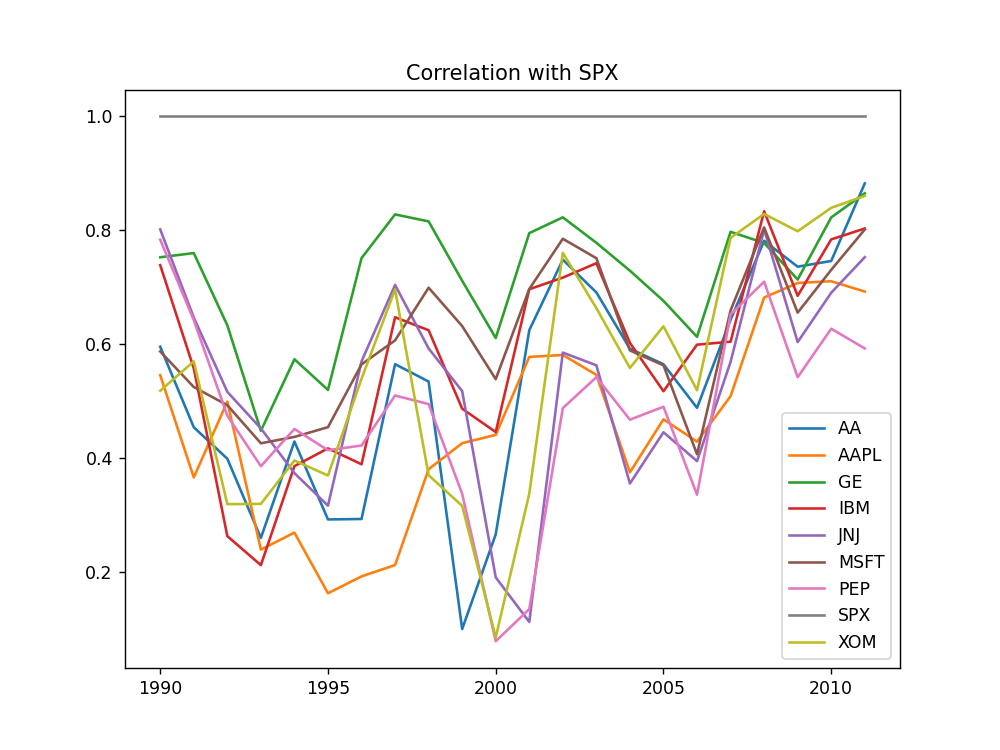

<AxesSubplot:title={'center':'Correlation with SPX'}>

In [127]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title("Correlation with SPX")
by_year.apply(spx_corr).plot(ax=ax1)

## 面向分组的线性回归



In [128]:
import statsmodels.api as sm

In [129]:
def reg(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    
    X['intercept'] = 1
    result = sm.OLS(Y, X).fit()
    
    return result.params

In [130]:
by_year.apply(reg, 'AAPL', ['SPX'])

,SPX,intercept
1990,1.512772,0.001395
1991,1.187351,0.000396
1992,1.832427,0.000164
1993,1.390470,-0.002657
1994,1.190277,0.001617
...,...,...
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261


# 透视表和交叉表

## 透视表

透视表(pivot table)是一种常见的数据汇总工具，根据一个或多个键对数据进行聚合，并根据行和列上的分组键将数据分配到各个矩形区域中。

- Pandas利用groupby功能和层次化索引的重塑运算制造透视表
- DataFrame的`pivot_table`方法，也是Pandas顶级函数。


In [131]:
tips

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Male,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,Male,No,Sat,Dinner,2,0.098204


In [132]:
tips.pivot_table(index='smoker', columns='sex', 
                 values=['total_bill', 'tip'])

tip           total_bill           
sex       Female      Male     Female       Male
smoker                                          
No      2.773519  3.113402  18.105185  19.791237
Yes     2.931515  3.051167  17.977879  22.284500

In [133]:
tips.pivot_table(index=['sex', 'day'], 
                 columns=['smoker'], values=['tip_pct', 'size'])

size             tip_pct          
smoker             No       Yes        No       Yes
sex    day                                         
Female Fri   2.500000  2.000000  0.165296  0.209129
       Sat   2.307692  2.200000  0.147993  0.163817
       Sun   3.071429  2.500000  0.165710  0.237075
       Thur  2.480000  2.428571  0.155971  0.163073
Male   Fri   2.000000  2.125000  0.138005  0.144730
       Sat   2.656250  2.629630  0.162132  0.139067
       Sun   2.883721  2.600000  0.158291  0.173964
       Thur  2.500000  2.300000  0.165706  0.164417

In [134]:
# 传入margins=True可以添加分项小计：All列为平均数
tips.pivot_table(index=['sex', 'day'], columns=['smoker'],
                 values=['tip_pct', 'size'],margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   2.500000  2.000000  2.111111  0.165296  0.209129  0.199388
       Sat   2.307692  2.200000  2.250000  0.147993  0.163817  0.156470
       Sun   3.071429  2.500000  2.944444  0.165710  0.237075  0.181569
       Thur  2.480000  2.428571  2.468750  0.155971  0.163073  0.157525
Male   Fri   2.000000  2.125000  2.100000  0.138005  0.144730  0.143385
       Sat   2.656250  2.629630  2.644068  0.162132  0.139067  0.151577
       Sun   2.883721  2.600000  2.810345  0.158291  0.173964  0.162344
       Thur  2.500000  2.300000  2.433333  0.165706  0.164417  0.165276
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

上述表中给出的是分组的平均值，这是分组的默认聚合类型。可以通过`aggfunc`参数进行修改，譬如`aggfunc=np.sum`进行汇总聚合。

In [135]:
df = pd.DataFrame(
    {
        "fruit": ["apple", "orange", "apple", "avocado", "orange"],
        "customer": ["ben", "alice", "ben", "josh", "steve"],
        "quantity": [1, 2, 3, 1, 2],
    }
)
df

,fruit,customer,quantity
0,apple,ben,1
1,orange,alice,2
2,apple,ben,3
3,avocado,josh,1
4,orange,steve,2


In [136]:
df.pivot_table(index="fruit", columns="customer", values="quantity", 
               aggfunc=np.sum)

customer,alice,ben,josh,steve
fruit,,,,
apple,NaN,4.0,NaN,NaN
avocado,NaN,NaN,1.0,NaN
orange,2.0,NaN,NaN,2.0


In [137]:
df.pivot_table(index="fruit", columns="customer", values="quantity",
               aggfunc=np.sum, fill_value=0)

customer,alice,ben,josh,steve
fruit,,,,
apple,0,4,0,0
avocado,0,0,1,0
orange,2,0,0,2


In [138]:
df.pivot_table(index="fruit", columns="customer", values="quantity",
               aggfunc=[np.sum, np.mean], 
               fill_value=0)

sum                 mean               
customer alice ben josh steve alice ben josh steve
fruit                                             
apple        0   4    0     0     0   2    0     0
avocado      0   0    1     0     0   0    1     0
orange       2   0    0     2     2   0    0     2

## 交叉表

交叉表（Cross-tabulation，简称cross-tab）是一种用于计算**分组频率**的特殊透视表。

In [139]:
data = pd.DataFrame({'Sample':np.arange(1,11), 
                    'Gender':['F','M','F','M','M','M','F','F','M','F'],
                    'Handness':['R','L','R','R','L','R','R','L','R','R']})
data

,Sample,Gender,Handness
0,1,F,R
1,2,M,L
2,3,F,R
3,4,M,R
4,5,M,L
5,6,M,R
6,7,F,R
7,8,F,L
8,9,M,R
9,10,F,R


In [140]:
data.pivot_table(index='Gender', columns='Handness', 
                 values='Sample', aggfunc='count',margins=True)

Handness,L,R,All
Gender,,,
F,1,4,5
M,2,3,5
All,3,7,10


In [141]:
pd.crosstab(data.Gender, data.Handness, margins=True)

Handness,L,R,All
Gender,,,
F,1,4,5
M,2,3,5
All,3,7,10


In [142]:
pd.crosstab(index=[tips.time, tips.day],
            columns=[tips.smoker], margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

## 综合性示例

In [144]:
corona = pd.read_csv('./examples/countries-aggregated.csv',
                     parse_dates=True)
corona

,Date,Country,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-23,Afghanistan,0,0,0
2,2020-01-24,Afghanistan,0,0,0
3,2020-01-25,Afghanistan,0,0,0
4,2020-01-26,Afghanistan,0,0,0
...,...,...,...,...,...
89659,2021-04-28,Zimbabwe,38191,35517,1565
89660,2021-04-29,Zimbabwe,38235,35594,1567
89661,2021-04-30,Zimbabwe,38257,35612,1567
89662,2021-05-01,Zimbabwe,38260,35620,1568


In [145]:
# 是否感染
corona['Infected'] = corona['Confirmed'] > 0

In [146]:
infected = corona.groupby('Date')['Infected'].sum()
infected

Date
2020-01-22      6
2020-01-23      8
2020-01-24      9
2020-01-25     11
2020-01-26     13
             ... 
2021-04-28    192
2021-04-29    192
2021-04-30    192
2021-05-01    192
2021-05-02    192
Name: Infected, Length: 467, dtype: int64

In [147]:
font_options = {'family':'SimSun','size':11}

plt.rc('font', **font_options)
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

<IPython.core.display.Javascript object>


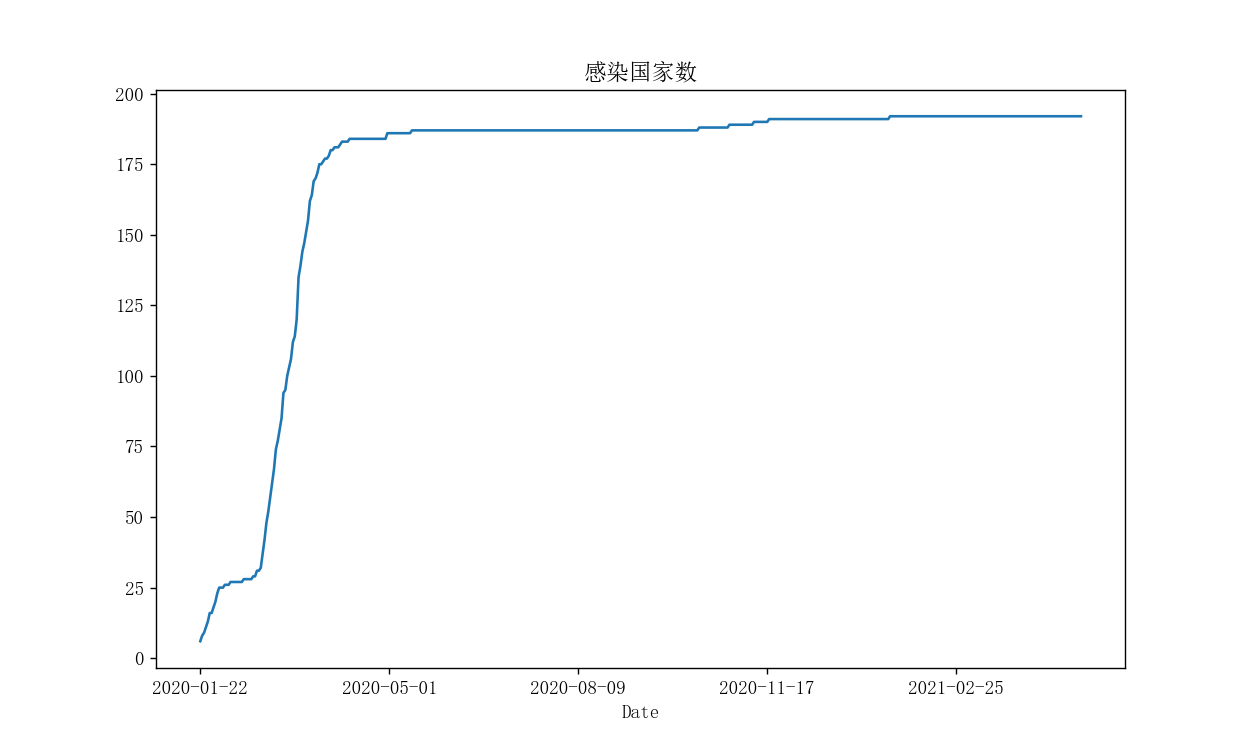

Text(0.5, 1.0, '感染国家数')

In [148]:
fig,ax2 = plt.subplots(1,1)
infected.plot(ax=ax2)
ax2.set_title("感染国家数")

感染国家按所在洲进行统计

需要对国家进行（国家-洲）匹配

In [150]:
countries = pd.read_csv("./examples/countries.csv")
countries

,Continent,Country
0,Africa,Algeria
1,Africa,Angola
2,Africa,Benin
3,Africa,Botswana
4,Africa,Burkina Faso
...,...,...
189,South America,Paraguay
190,South America,Peru
191,South America,Suriname
192,South America,Uruguay


In [151]:
df = pd.merge(corona, countries, 
              left_on='Country', right_on='Country', how='inner') # 因国家名称信息不统一，忽略掉少量数据
df

,Date,Country,Confirmed,Recovered,Deaths,Infected,Continent
0,2020-01-22,Afghanistan,0,0,0,False,Asia
1,2020-01-23,Afghanistan,0,0,0,False,Asia
2,2020-01-24,Afghanistan,0,0,0,False,Asia
3,2020-01-25,Afghanistan,0,0,0,False,Asia
4,2020-01-26,Afghanistan,0,0,0,False,Asia
...,...,...,...,...,...,...,...
84522,2021-04-28,Zimbabwe,38191,35517,1565,True,Africa
84523,2021-04-29,Zimbabwe,38235,35594,1567,True,Africa
84524,2021-04-30,Zimbabwe,38257,35612,1567,True,Africa
84525,2021-05-01,Zimbabwe,38260,35620,1568,True,Africa


In [152]:
countries = pd.pivot_table(index='Date', columns='Continent',
                           values='Infected',data=df, aggfunc=sum)
countries

Continent,Africa,Asia,Europe,North America,Oceania,South America
Date,,,,,,
2020-01-22,0,4,0,1,0,0
2020-01-23,0,6,0,1,0,0
2020-01-24,0,6,1,1,0,0
2020-01-25,0,8,1,1,0,0
2020-01-26,0,8,1,2,1,0
...,...,...,...,...,...,...
2021-04-28,52,41,44,23,9,12
2021-04-29,52,41,44,23,9,12
2021-04-30,52,41,44,23,9,12


<IPython.core.display.Javascript object>


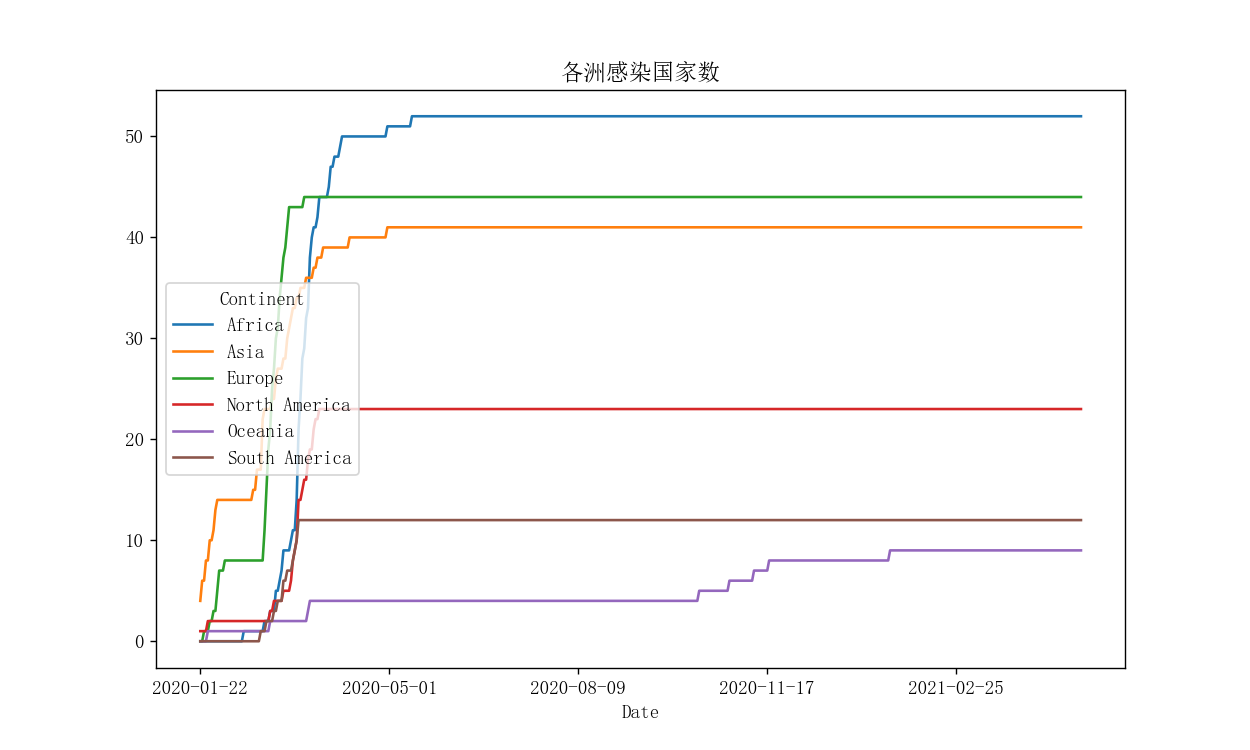

Text(0.5, 1.0, '各洲感染国家数')

In [153]:
fig3,ax3 = plt.subplots(1,1)
countries.plot(ax=ax3)
ax3.set_title("各洲感染国家数")

In [154]:
patients = pd.pivot_table(index='Date', columns='Continent',
                          values=['Infected','Deaths'],data=df, aggfunc=sum)
patients

Deaths                                                      \
Continent   Africa    Asia  Europe North America Oceania South America   
Date                                                                     
2020-01-22       0      17       0             0       0             0   
2020-01-23       0      18       0             0       0             0   
2020-01-24       0      26       0             0       0             0   
2020-01-25       0      42       0             0       0             0   
2020-01-26       0      56       0             0       0             0   
...            ...     ...     ...           ...     ...           ...   
2021-04-28  120176  601587  879546        844732    1046        663348   
2021-04-29  120572  607095  882418        846288    1046        667863   
2021-04-30  120827  612577  884939        847942    1046        672415   
2021-05-01  121111  618086  886964        848797    1054        675994   
2021-05-02  121340  619854  888138        849269    1054        678778   

           Infected                                                  
Continent    Africa Asia Europe North America Oceania South America  
Date                                                                 
2020-01-22        0    4      0             1       0             0  
2020-01-23        0    6      0             1       0             0  
2020-01-24        0    6      1             1       0             0  
2020-01-25        0    8      1             1       0             0  
2020-01-26        0    8      1             2       1             0  
...             ...  ...    ...           ...     ...           ...  
2021-04-28       52   41     44            23       9            12  
2021-04-29       52   41     44            23       9            12  
2021-04-30       52   41     44            23       9            12  
2021-05-01       52   41     44            23       9            12  
2021-05-02       52   41     44            23       9            12  

[467 rows x 12 columns]

<IPython.core.display.Javascript object>


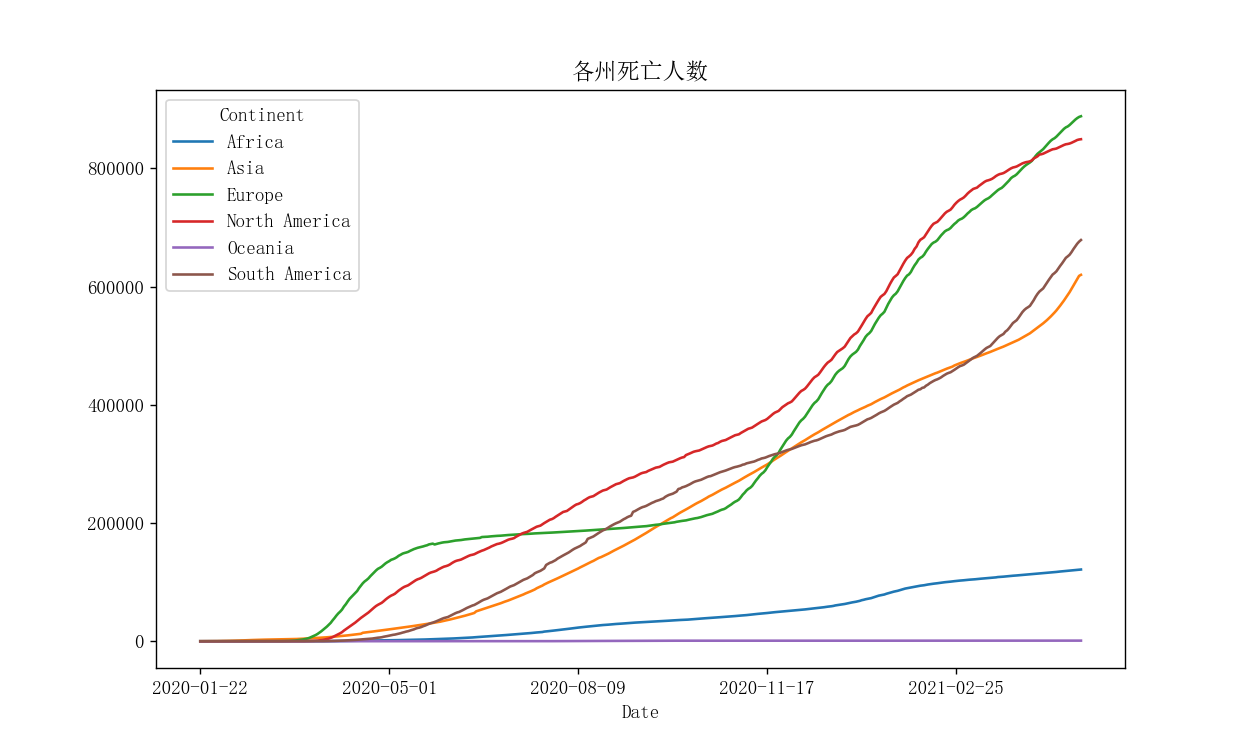

Text(0.5, 1.0, '各州死亡人数')

In [155]:
fig4,ax4 = plt.subplots(1,1)
patients['Deaths'].plot(ax=ax4)
ax4.set_title("各州死亡人数")